In [338]:
%load_ext autoreload
%autoreload 2

import optuna
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import shap
import numpy as np
import scipy
import seaborn as sns

from steps.prepare_data import load_processed_data, load_split_processed_data
from utils.model import predict, load_model, predict_booster, predict_booster_model
from steps.load_data import LoadData

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [339]:
data_loader = LoadData()

# data_loader.df_train_fe.abon_id
df_train_bnum = data_loader.df_train_bnum.copy()

df_train_bnum["target"] = 0

abon_target = data_loader.df_train_fe[["target", "abon_id"]]

df_train_bnum["target"] = df_train_bnum["abon_id"].map(abon_target.set_index("abon_id")["target"])

# Percentage of boolean columns
df_train_bnum["target"].value_counts(normalize=True)

df_train_bnum = df_train_bnum.copy()

activity_columns = [
    "call_cnt_out",
    "call_cnt_in",
    "call_dur_out",
    "call_dur_in",
    "cnt_sms_out",
    "cnt_sms_in",
]

In [ ]:
# # Fetch phone number information

# import requests
# import json


# short_numbers_dict = {}

# short_numbers = [
#     "111",
#     "1020",
#     "275",
#     "3700",
#     "277",
#     "5010",
#     "3135",
#     "273",
#     "3133",
#     "112",
#     "7777",
#     "1545",
#     "4224",
#     "1525",
#     "30094",
#     "1648",
#     "2233",
#     "555",
#     "1551",
#     "30043",
#     "2250",
#     "1050",
#     "225",
#     "1535",
#     "1648",
#     "5000",
#     "4666",
# ]

In [3]:
def fetch_phone_information(short_number: str):
    try:
        base_url = "https://www.vodafone.ua/api/short_numbers/?short_number={variable}&Voice=on&SMS=on"

        url = base_url.format(variable=short_number)

        response = requests.get(url)

        payload = json.loads(response.content.decode("utf-8"))

        return payload["data"][0]["title"]
    except:
        return "Not found"

In [ ]:
# for number in short_numbers:
#     short_numbers_dict[number] = fetch_phone_information(number)

short_numbers_dict

{'111': 'Служба підтримки VODAFONE Україна',
 '1020': 'Автоматичні налаштування Мобільного Інтернету ',
 '275': 'NPS-опитування компанії Vodafone',
 '3700': 'М-Банкінг',
 '277': 'NSAT- опитування компанії Vodafone, про задоволеність обслуговуванням в компанії',
 '5010': 'Гроші на замовлення',
 '3135': 'Служба таксі',
 '273': 'NPS-опитування компанії Vodafone',
 '3133': 'Служба таксі',
 '112': 'Рятувальна служба',
 '7777': 'Міграція в інший тариф Vodafone',
 '1545': 'Державний контактний центр',
 '4224': 'Соціальний проект Ю-Репорт @UReportUkraine',
 '1525': 'Not found',
 '30094': 'Vodafone TV. Пакет PRO',
 '1648': 'ДЕРЖАВНА УСТАНОВА "УРЯДОВИЙ КОНТАКТНИЙ ЦЕНТР"',
 '2233': 'Служба таксі',
 '555': 'Not found',
 '1551': 'Контактний Центр міста Києва',
 '30043': 'Not found',
 '2250': 'Інтерактивний проект ТОВ «Телесвіт» (volia.com)',
 '1050': 'Not found',
 '225': '"Топливо в наявності"',
 '1535': 'Інформаційни портал Харківської міської ради',
 '5000': 'Not found',
 '4666': 'Not found'}

In [340]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import time


def get_phonebook_header(phone_number):
    url = "https://www.telefonnyjdovidnyk.com.ua/"

    # Set up headless Chrome
    chrome_options = Options()
    chrome_options.add_argument("--headless")
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--no-sandbox")

    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)

    # Open the URL
    driver.get(url)

    # Find the search input, enter the phone number, and submit the form
    search_input = driver.find_element("name", "search")
    search_input.send_keys(phone_number)
    search_input.submit()

    # Wait for the page to load (you may need to adjust the sleep time)
    time.sleep(3)

    # Get the page source and parse it with BeautifulSoup
    soup = BeautifulSoup(driver.page_source, "html.parser")

    # Look for the phonebook-header class
    phonebook_header = soup.find(class_="phonebook-header")

    # If not found, look for the first h3 tag
    if not phonebook_header:
        phonebook_header = soup.find("h3")

    driver.quit()

    if phonebook_header:
        header_text = phonebook_header.get_text(strip=True)
        return {"header": header_text}
    else:
        return {"error": "phonebook-header or h3 not found"}

In [ ]:
some_numbers_dict = {}

In [ ]:
# for number in some_numbers:
#     print("Fetching", number)

#     if some_numbers_dict.get(number) and some_numbers_dict.get(number) != "phonebook-header or h3 not found":
#         print("Already fetched", some_numbers_dict[number])
#         continue

#     some_numbers_dict[number] = get_phonebook_header(number)
#     print("Fetched", some_numbers_dict[number])

Fetching 380800210800
Already fetched {'header': 'Аферисти Київ'}
Fetching 380800500500
Already fetched {'header': 'РАЙФФАЙЗЕН БАНК АВАЛЬ, ПАТ, ДНІПРОПЕТРОВСЬКАОБЛАС'}
Fetching 380800305555
Already fetched {'header': 'Телефонне шахрайство: у МВС розповіли, хто і як виманює гроші в українців'}
Fetching 380800500850
Already fetched {'header': 'КРЕДОБАНК,АТ'}
Fetching 380800307010
Fetched {'header': 'БАНК ВОСТОК,ПАТ'}
Fetching 380800502050
Fetched {'header': 'SenseBank'}
Fetching 380800504450
Fetched {'header': 'ЕКСПОРТНО-ІМПОРТНИЙ БАНК УКРАЇНИ, ПАТ, ЧЕРНІВЕЦЬКАФІЛІЯ'}
Fetching 380800502030
Fetched {'header': 'ІДЕЯ БАНК,АТ'}
Fetching 380800507700
Fetched {'header': 'БАНК КРЕДИТ ДНІПРО,АТ'}
Fetching 380800504400
Fetched {'header': 'МЕГАБАНК,АТ'}
Fetching 380800309000
Fetched {'header': 'УКРГАЗБАНК, АКЦІОНЕРНИЙБАНК'}
Fetching 380800307030
Fetched {'header': 'ПІВДЕННИЙ, ПУБЛІЧНЕ АТ АКЦІОНЕРНИЙБАНК'}
Fetching 380800500850
Already fetched {'header': 'КРЕДОБАНК,АТ'}
Fetching 380442474040
Fetche

In [ ]:
some_numbers_dict = {
    "380800210800": {"header": "Аферисти Київ"},
    "380800500500": {"header": "РАЙФФАЙЗЕН БАНК АВАЛЬ, ПАТ, ДНІПРОПЕТРОВСЬКАОБЛАС"},
    "380800305555": {"header": "Телефонне шахрайство: у МВС розповіли, хто і як виманює гроші в українців"},
    "380800500850": {"header": "КРЕДОБАНК,АТ"},
    "380800307010": {"header": "БАНК ВОСТОК,ПАТ"},
    "380800502050": {"header": "SenseBank"},
    "380800504450": {"header": "ЕКСПОРТНО-ІМПОРТНИЙ БАНК УКРАЇНИ, ПАТ, ЧЕРНІВЕЦЬКАФІЛІЯ"},
    "380800502030": {"header": "ІДЕЯ БАНК,АТ"},
    "380800507700": {"header": "БАНК КРЕДИТ ДНІПРО,АТ"},
    "380800504400": {"header": "МЕГАБАНК,АТ"},
    "380800309000": {"header": "УКРГАЗБАНК, АКЦІОНЕРНИЙБАНК"},
    "380800307030": {"header": "ПІВДЕННИЙ, ПУБЛІЧНЕ АТ АКЦІОНЕРНИЙБАНК"},
    "380442474040": {"header": "КИЇВТЕПЛОЕНЕРГО,КП"},
    "380442907290": {"header": "ПЕРШИЙ УКРАЇНСЬКИЙ МІЖНАРОДНИЙБАНК"},
    "380443630133": {"header": "ОЩАДБАНК, УКРАЇНСЬКИЙ КОМЕРЦІЙНИЙБАНК"},
    "380442020202": {
        "header": "У Черкасах телефонні шахраї заробляють десятки тисяч гривень на довірливості містян"
    },
    "380443519998": {"header": "Інтерес до цього номера за останній місяць"},
    "380443519999": {"header": "ЮНІКАСТ ІНВЕСТ,ТОВ"},
    "380442050020": {"header": "СІНЕВО УКРАЇНА,ТОВ"},
    "380442329925": {"header": "ЗАКАЗ. ЮА,ТОВ"},
    "380442021588": {"header": "КИЇВ ЕНЕРГО,АТ"},
    "380442224222": {"header": "СПОРТ ЛАЙФ УКРАЇНА,ТОВ"},
    "380442470786": {"header": "STIL EVROTOV"},
    "380444590740": {"header": "КИЇВОБЛЕНЕРГО"},
    "380444908888": {"header": "РАЙФФАЙЗЕН БАНК АВАЛЬ,АТ"},
    "380444950405": {"header": "Як не стати жертвою телефонних шахраїв"},
    "380444944320": {"header": "Інтерес до цього номера за останній місяць"},
    "380444900500": {"header": "ОТП БАНК,АТ"},
    "380445038080": {"header": "Це виртуальний оператор"},
    "380445276363": {"header": "Як не стати жертвою телефонних шахраїв. Пояснюють експерти"},
    "380445370222": {"header": "Телефонне платіжне шахрайство –#ШахрайГудбай"},
    "380445001717": {
        "header": "У Черкасах телефонні шахраї заробляють десятки тисяч гривень на довірливості містян"
    },
    "380445000303": {"header": "ХАРДТЕХСЕРВІС,ТОВ"},
    "380442901988": {"header": "Шахрайство в мережі та телефонне шахрайство"},
    "380442221111": {"header": "Як діяти українцям, коли телефонують шахраї"},
    "380442204404": {
        "header": "Обережно: телефонне шахрайство! Чернігівців «розводять» на гроші під час пошуку роботи"
    },
    "380442220333": {
        "header": "КІБЕРПОЛІЦІЯ ЗАСТЕРІГАЄ ВІД ТЕЛЕФОННИХ ШАХРАЇВ, ЯКІ ВИДАЮТЬ СЕБЕ ЗА СПІВРОБІТНИКІВ БАНКУ"
    },
    "380442009010": {"header": "Мошенники “разводят” предпринимателей"},
    "380487059090": {"header": "Інтерес до цього номера за останній місяць"},
    "380487300030": {"header": "ODREX, МЕДИЧНИЙДІМ"},
    "380487055555": {"header": "Телефонне шахрайство: у МВС розповіли, хто і як виманює гроші в українців"},
    "380567934826": {"header": "STANTSIYA DNIPROPETROVSKFILIA"},
    "380567878104": {"header": "На Рівненщині 1,5 року обмеження волі за телефонне шахрайство отримав волинянин"},
    "380567900999": {"header": "Інтерес до цього номера за останній місяць"},
    "380577075757": {"header": "ХАРКІВВОДОКАНАЛ,КП"},
    "380577209720": {"header": "МАКСНЕТ"},
    "380577665104": {"header": "ХАРКІВМІСЬКГАЗ,ПАТ"},
    "380666163133": {"header": "На Рівненщині за зухвале телефонне шахрайство піде під суд житель Миколаївщини"},
    "380670107104": {"header": "ХАРКІВМІСЬКГАЗ,ПАТ"},
    "380674660466": {"header": "Київстар"},
    "380677880884": {"header": "Що треба знати про мобільне шахрайство"},
    "380931710000": {"header": "ЦЕНТР ЦИФРАЛ СЕРВІС ЗАПОРІЖЖЯ,ТОВ"},
    "380931771611": {"header": "ЛАЗЕРХАУЗ,ТОВ"},
    "380952331515": {"header": "ЗАПОРІЗЬКІ ЦИФРОВІ КОМУНІКАЦІЇ,ТОВ"},
    "380957321212": {
        "header": "Які види шахрайства розповсюджені на Житомирщині і як не стати жертвою шахраїв, розповіли у…"
    },
    "380958788181": {
        "header": "КІБЕРПОЛІЦІЯ ЗАСТЕРІГАЄ ВІД ТЕЛЕФОННИХ ШАХРАЇВ, ЯКІ ВИДАЮТЬ СЕБЕ ЗА СПІВРОБІТНИКІВ БАНКУ"
    },
    "380962907290": {"header": "ПЕРШИЙ УКРАЇНСЬКИЙ МІЖНАРОДНИЙБАНК"},
    "380984500609": {"header": "НОВА ПОШТА,КОМПАНІЯ"},
    "380995055757": {
        "header": "НАЦІОНАЛЬНИЙ БАНК УКРАЇНИ ЗАПУСТИВ ІНФОРМАЦІЙНУ КАМПАНІЮ З ПРОТИДІЇ ШАХРАЙСТВУ #ШАХРАЙГУДБАЙ"
    },
    "380997344444": {"header": "ФРЕГАТ ІСП,ТОВ"},
}

len(some_numbers_dict)

{'380800210800': {'header': 'Аферисти Київ'},
 '380800500500': {'header': 'РАЙФФАЙЗЕН БАНК АВАЛЬ, ПАТ, ДНІПРОПЕТРОВСЬКАОБЛАС'},
 '380800305555': {'header': 'Телефонне шахрайство: у МВС розповіли, хто і як виманює гроші в українців'},
 '380800500850': {'header': 'КРЕДОБАНК,АТ'},
 '380800307010': {'header': 'БАНК ВОСТОК,ПАТ'},
 '380800502050': {'header': 'SenseBank'},
 '380800504450': {'header': 'ЕКСПОРТНО-ІМПОРТНИЙ БАНК УКРАЇНИ, ПАТ, ЧЕРНІВЕЦЬКАФІЛІЯ'},
 '380800502030': {'header': 'ІДЕЯ БАНК,АТ'},
 '380800507700': {'header': 'БАНК КРЕДИТ ДНІПРО,АТ'},
 '380800504400': {'header': 'МЕГАБАНК,АТ'},
 '380800309000': {'header': 'УКРГАЗБАНК, АКЦІОНЕРНИЙБАНК'},
 '380800307030': {'header': 'ПІВДЕННИЙ, ПУБЛІЧНЕ АТ АКЦІОНЕРНИЙБАНК'},
 '380442474040': {'header': 'КИЇВТЕПЛОЕНЕРГО,КП'},
 '380442907290': {'header': 'ПЕРШИЙ УКРАЇНСЬКИЙ МІЖНАРОДНИЙБАНК'},
 '380443630133': {'header': 'ОЩАДБАНК, УКРАЇНСЬКИЙ КОМЕРЦІЙНИЙБАНК'},
 '380442020202': {'header': 'У Черкасах телефонні шахраї заробляють десятки тисяч

In [342]:
# df_train_bnum.bnum.value_counts().sort_values(ascending=False).index.to_list()

bank_companies = [
    "privatbank",
    "oschadbank",
    "raiffeisen",
    "monobank",
    "mono",
    "alfabank",
    "pumb",
    "otp bank",
    "ukrgasbank",
    "a-bank",
    "tascombank",
    "ukreximbank",
    "bankvostok",
    "pivdenny",
    "globusbank",
    "ukreximban",
    "poltavaban",
    "bank bls",
    "accordbank",
    "creditdnepr",
    "megabank",
    "concordbank",
    "radabank",
    "procredit",
    "industrial",
    "pravex ban",
    "rws bank",
    "bankago",
    "credobank",
    "forwardban",
    "sportbank",
    "idea bank",
    "mtb bank",
    "piraeusbank",
    "bankforward",
    "alf-ua.com",
    "kredobank",
    "sichbank",
    "izibank",
    "pumb onlin",
    "ideabank",
]

work_companies = [
    "rabota.ua",
    "work.ua",
    "jooble",
    "linkedin",
    "itstep",
    "skillup",
    "rabota",
    "start-work",
]

grocery_companies = [
    "varus",
    "silpo",
    "fozzy",
    "myasomarke",
    "metro",
    "tavria_v",
    "eko market",
    "фрукты",
]

post_companies = [
    "380984500609",
    "novaposhta",
]

taxy_companies = [
    "taxi-838",
    "uklon",
    "bolt",
    "uber",
    "shark taxi",
    "taxi 3040",
    "opti-579",
    "ontaxi",
    "taxi 2288",
    "taxi vezi",
    "taxi 323",
    "taxi 571",
    "taxi-808",
    "eco taxi",
    "taxi-280",
    "taximer",
    "taxi 309",
    "taxi 777",
    "taxi-653",
    "taxi 959",
    "2233",
    "3135",
    "3133",
]

credits_companies = [
    "credit_plus",
    "credit7.ua",
    "mycredit",
    "ze.kredit",
    "moneyveo",
    "mycredit.ua",
    "creditdnepr",
    "e-groshi",
    "credit7",
    "clickcredit",
    "soscredit",
    "crediton",
    "creditexpr",
    "creditdnep",
    "credit_plus",
    "creditplu",
    "creditdebt",
    "zecredit",
    "kredit",
    "alexcredit",
    "shgroshi",
    "creditpod",
    "credit7.ua",
    "money4you",
    "dinero",
    "kreditytut",
    "creditpod-0",
    "clickcredi",
    "kredit4u",
    "e-wings",
    "creditexpr",
    "minizaem",
    "money24",
    "moneyboom",
    "moneyextra",
    "moneylove",
    "zss",
    "creditplus",
    "k-kapital",
    "egroshicom",
    "skarbcomua",
    "credit_plu",
    "miloan.ua",
    "mycredit-u",
    "mycredit-ua",
    "mycredit.u",
    "ua-mycredi",
    "ua-mycredit",
    "mycreditua",
    "ccloan",
    "loanyua",
    "ze.kred1t",
    "selficredi",
    "mistercash",
    "selficredit",
    "sos credit",
    "zecredi",
    "dengi dozp",
    "otp credit",
    "ze_kred1t",
    "sloncredit",
    "bingocash",
    "cash point",
    "cashberry",
    "slon credi",
    "domonet",
    "yoomoney",
    "creditpod-",
    "slon credit",
    "moneta-z",
    "bankacredi",
    "cash-kf",
    "advcash",
    "money.4.yo",
    "moneyexpert",
    "money-4-yo",
    "aviracredi",
    "money-4-you",
    "icredit",
    "creditbox",
    "money.4.you",
    "credit",
    "zekredi",
    "el caso",
    "creditup",
    "monetka",
    "dengivsim",
    "credit365",
    "moneyexper",
    "aviracredit",
    "kredit plu",
    "crediglbl",
    "bestcredit",
    "neocredit",
    "cashhelp",
    "telmone",
    "microcash",
    "novikredyt",
    "extramoney",
    "clycredit",
    "creditcafe",
    "ewacash",
    "kg-money",
    "creditik",
    "casharing",
    "case 24",
    "kreditstar",
    "forzacredit",
    "webmoney.ua",
    "forzacredi",
    "kredit plus",
    "ecase",
    "caseshop",
    "webmoney.u",
    "macincase",
    "verocash",
    "techno-cas",
    "novikredyty",
    "cash24",
    "onlycredit",
    "portmone",
    "mrmoney",
    "globalcredi",
    "credit-pro",
    "cashdesk",
    "stormoney",
    "credit2u",
    "opencredit",
    "smartmoney",
    "kvk-cash",
    "hotcredit",
    "techno-case",
    "cash365",
    "bestcredits",
    "bankacredit",
    "cash-ua",
    "sweet mone",
    "kredit1",
    "cashinua",
    "sweetmoney",
    "tviy cash",
    "moneyua",
    "catcredit",
    "money.spac",
    "topcredit",
    "sweet money",
    "pvks-kredit",
    "fotocaseua",
    "cashinsky",
    "easy cash",
    "yourmoney",
    "credbox",
    "kreditavans",
    "credit24",
    "casinoin",
    "globalcred",
    "caseller",
    "n1casino",
    "recredit",
    "happycredi",
    "uitracredit",
    "onecase",
    "seacredit",
    "smartcredi",
    "moneysmash",
    "pvks-kredi",
    "gdcashmere",
    "cool credi",
    "mlcrocredit",
    "turbocash",
    "allrightcas",
    "bystro.cas",
    "kreditavan",
    "blago cash",
    "ultracredi",
    "e-cash",
    "creditmax",
    "money_poin",
    "icases.ua",
    "dengi24",
    "hit_cash",
    "credit ok",
    "intercash",
    "monese",
    "elitcredit",
    "ify.credit",
    "dorcas",
    "moneyglad",
    "ifycredit",
    "uakredit",
    "bystro.cash",
    "kreditor",
    "dengidengi",
    "cashbe",
    "micredit",
    "casemaniac",
    "crazy case",
    "silver_cas",
    "sens credit",
    "mlcrocredi",
    "casey",
    "atom case",
    "cascata",
    "cashbox",
    "luckycash",
    "creditavir",
    "glad4money",
    "casekey",
    "kredit vsem",
    "multicast",
    "ultracashua",
    "hypno-casa",
    "avanscredit",
    "money_help",
    "casofficial",
    "incredo",
    "jeanscasual",
    "4-cases",
    "cool credit",
    "simplemone",
    "moneyup",
    "unicredit",
    "secretcase",
    "silvermone",
    "moneyjar",
    "nillkincase",
    "oncredit",
    "pancredit",
    "the-credit",
    "kredit_112",
    "flashcash",
    "creditbot",
    "creditorxx",
    "money_flas",
    "elitcases",
    "money_flash",
    "globalmone",
    "selectmoney",
    "prostomone",
    "kredenscafe",
    "moneyvalue",
    "sens credi",
    "money_star",
    "1case",
    "credit4u",
    "uitracredi",
    "mistermoney",
    "credit bot",
    "micrediton",
    "bit_money",
    "monet home",
    "tuskcasino",
    "casofficia",
    "prostomoney",
    "ultracredit",
    "reficredit",
    "ab.case",
    "money club",
    "moneysend",
    "creditnice1",
    "creditlite",
    "personcase",
    "bananacred",
    "likemoney",
    "creditavira",
    "pocketmone",
    "new_money",
]


food_delivery_companies = [
    "dominos",
    "sushi wok",
    "sushimaster",
    "sushi icons",
    "pizza 33",
    "sushimaste",
    "sushimaste",
    "glovo",
    "budusushi",
    "smilefood",
    "sushimaster",
    "sushi-poin",
    "sushi boss",
    "sushimaste",
    "sushimaste",
]


health_companies = [
    "e-health",
    "apteka911",
    "synevo",
    "helsi",
    "medcard24",
    "24/7 лікар",
    "med-servic",
    "med-service",
    "medcity.ua",
    "liki24.com",
    "apteka24.ua",
    "aptekanetu",
    "apteka d.s.",
    "podorozhnyk",
    "med-servlc",
    "apteka nc",
    "podorozhny",
    "med-servlce",
    "likar.info",
    "medcity",
    "likar",
    "apteka d.s",
    "leleka",
]

delivery_companies = [
    "novaposhta",
    "ukrposhta",
    "meestua",
    "global24",
]

competitors_companies = [
    "kyivstar",
    "vodafone ua",
    "lifecell",
    "kyivdigital",
]

competitors_provider_companies = [
    "ukrtelecom",
    "triolan",
    "datagroup",
    "langate",
    "fregat.com",
    "volia",
    "vega",
    "viasat",
]

shops_companies = [
    "rozetka",
    "prom.ua",
    "allo",
    "olx",
    "makeup",
    "citrus.ua",
    "stylus",
    "eldorado",
    "comfy",
    "foxtrot.ua",
    "epicentrk",
    "colins",
    "eva",
    "yakaboo",
    "exist.ua",
    "metro",
    "eva-mozayk",
    "mycredit.ua",
    "epic games",
    "bonjour",
    "citrus",
    "dzvlnok",
    "domino's",
    "fast box",
    "gift-servi",
    "kids-room",
    "kioto",
    "lemon.box",
    "link.dating",
    "mall",
    "medav",
    "ohlala",
    "photo-room",
    "pond",
    "rozetka, магазин",
    "shopster",
    "sofa_dream",
    "stay.cafe",
    "студия",
    "студия.меб",
    "ушастик",
    "холдинг",
    "цифровой",
    "шары",
    "shop_zakaz",
    "top-shop",
    "віці",
    "інтернет",
    "юа_магазин",
]

messengars_companies = [
    "viber",
    "whatsapp",
    "telegram",
    "facebook",
    "google",
    "instagram",
    "tiktok",
    "snapchat",
    "linkedin",
    "zoom",
    "discord",
    "twitter",
]

cyberpolice_companies = [
    "cyberpolice",
    "cyberpolic",
]

vodafone_support = [
    "111",
]

vodafone_survey = [
    "273",
    "275",
    "277",
]

vodafone_new_customer = [
    "222",
]

vodafone_services = [
    "30094",
    "7777",
    "30094",
    "5010",
    "1020",
    "2828",
    "30042",
    "vodafone u",
]

fraud_numbers = [
    "380800305555",
    "380442020202",
    "380444950405",
    "380445276363",
    "380445370222",
    "380442220333",
    "380442009010",
    "380442204404",
    "380442901988",
    "380567878104",
    "380666163133",
    "380677880884",
    "380957321212",
    "380958788181",
    "380443519998",
    "380995055757",
    "380800210800",
]

bank_numbers = [
    "380800500500",
    "380800500850",
    "380800307010",
    "380800502050",
    "380800504450",
    "380800502030",
    "380800507700",
    "380800504400",
    "380800309000",
    "380800307030",
    "380442907290",
    "380443630133",
    "380444908888",
    "380444900500",
    "380962907290",
    "729",
    "3700",
]

competitors_numbers = [
    "380674660466",
    "380997344444",
    "380505022250",
]

rescue_numbers = [
    "112",
    "102",
    "103",
    "dsns ukr",
]

verify_numbers = [
    "verify",
]

phone_companies = [
    "xiaomi",
    "apple",
    "samsung",
    "huawei",
]

In [345]:
bnum_categories_dict = {
    "bank_companies": bank_companies,
    "work_companies": work_companies,
    "grocery_companies": grocery_companies,
    "post_companies": post_companies,
    "taxy_companies": taxy_companies,
    "credits_companies": credits_companies,
    "food_delivery_companies": food_delivery_companies,
    "health_companies": health_companies,
    "delivery_companies": delivery_companies,
    "competitors_companies": competitors_companies,
    "competitors_provider_companies": competitors_provider_companies,
    "shops_companies": shops_companies,
    "messengars_companies": messengars_companies,
    "cyberpolice_companies": cyberpolice_companies,
    "vodafone_support": vodafone_support,
    "vodafone_survey": vodafone_survey,
    "vodafone_services": vodafone_services,
    "vodafone_new_customer": vodafone_new_customer,
    "fraud_numbers": fraud_numbers,
    "bank_numbers": bank_numbers,
    "competitors_numbers": competitors_numbers,
    "rescue_numbers": rescue_numbers,
    "verify_numbers": verify_numbers,
    "phone_companies": phone_companies,
}

df_train_bnum["bnum_category"] = "other"

for category, numbers in bnum_categories_dict.items():
    df_train_bnum["bnum_category"] = np.where(
        df_train_bnum["bnum"].isin(numbers), category, df_train_bnum["bnum_category"]
    )

vodafone_all = ["vodafone_support", "vodafone_survey", "vodafone_services", "vodafone_new_customer"]

df_train_bnum["vodafone"] = np.where(df_train_bnum["bnum_category"].isin(vodafone_all), True, False)

In [344]:
import re


def check_word(word):
    return bool(re.search(r"грош|mone|деньг|deng|cas|cred|кред|kred", word, re.IGNORECASE))


others_bnums = (
    df_train_bnum[df_train_bnum.bnum_category == "other"]
    .bnum.value_counts()
    .sort_values(ascending=False)
    .index.to_list()
)

credit_phrases = []

for phrase in others_bnums:
    if check_word(phrase):
        credit_phrases.append(phrase)

credit_phrases

[]

In [346]:
churn_true = df_train_bnum[df_train_bnum["target"] == 1]
churn_false = df_train_bnum[df_train_bnum["target"] == 0]

In [347]:
churn_true.bnum_category.value_counts(normalize=True).sort_values(ascending=False).head(10)

bnum_category
other                    0.339511
cyberpolice_companies    0.150509
bank_companies           0.098900
messengars_companies     0.085743
vodafone_services        0.076741
vodafone_support         0.037923
credits_companies        0.033238
taxy_companies           0.031650
vodafone_survey          0.029613
rescue_numbers           0.021385
Name: proportion, dtype: float64

In [348]:
churn_false.bnum_category.value_counts(normalize=True).sort_values(ascending=False).head(10)

bnum_category
other                    0.395539
cyberpolice_companies    0.156486
bank_companies           0.109495
messengars_companies     0.054749
taxy_companies           0.047852
delivery_companies       0.029451
vodafone_survey          0.026369
credits_companies        0.026083
rescue_numbers           0.024446
vodafone_services        0.022187
Name: proportion, dtype: float64

In [458]:
def build_feature_share_df(dataframe, feature_name, agg="sum"):
    df = (
        dataframe.groupby("bnum_category")
        .agg({feature_name: agg})
        .sort_values(by=feature_name, ascending=False)
        .reset_index()
    )

    df[f"{feature_name}_share"] = (df[feature_name] / df[feature_name].sum()) * 100

    return df


def bnum_category_grouped_feature_histplot(dataframe, feature_name, agg="sum", **params):
    df = build_feature_share_df(dataframe, feature_name, agg=agg)

    return sns.histplot(
        data=df,
        x="bnum_category",
        weights=f"{feature_name}_share",
        discrete=True,
        kde=False,
        **params,
    )

/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na 

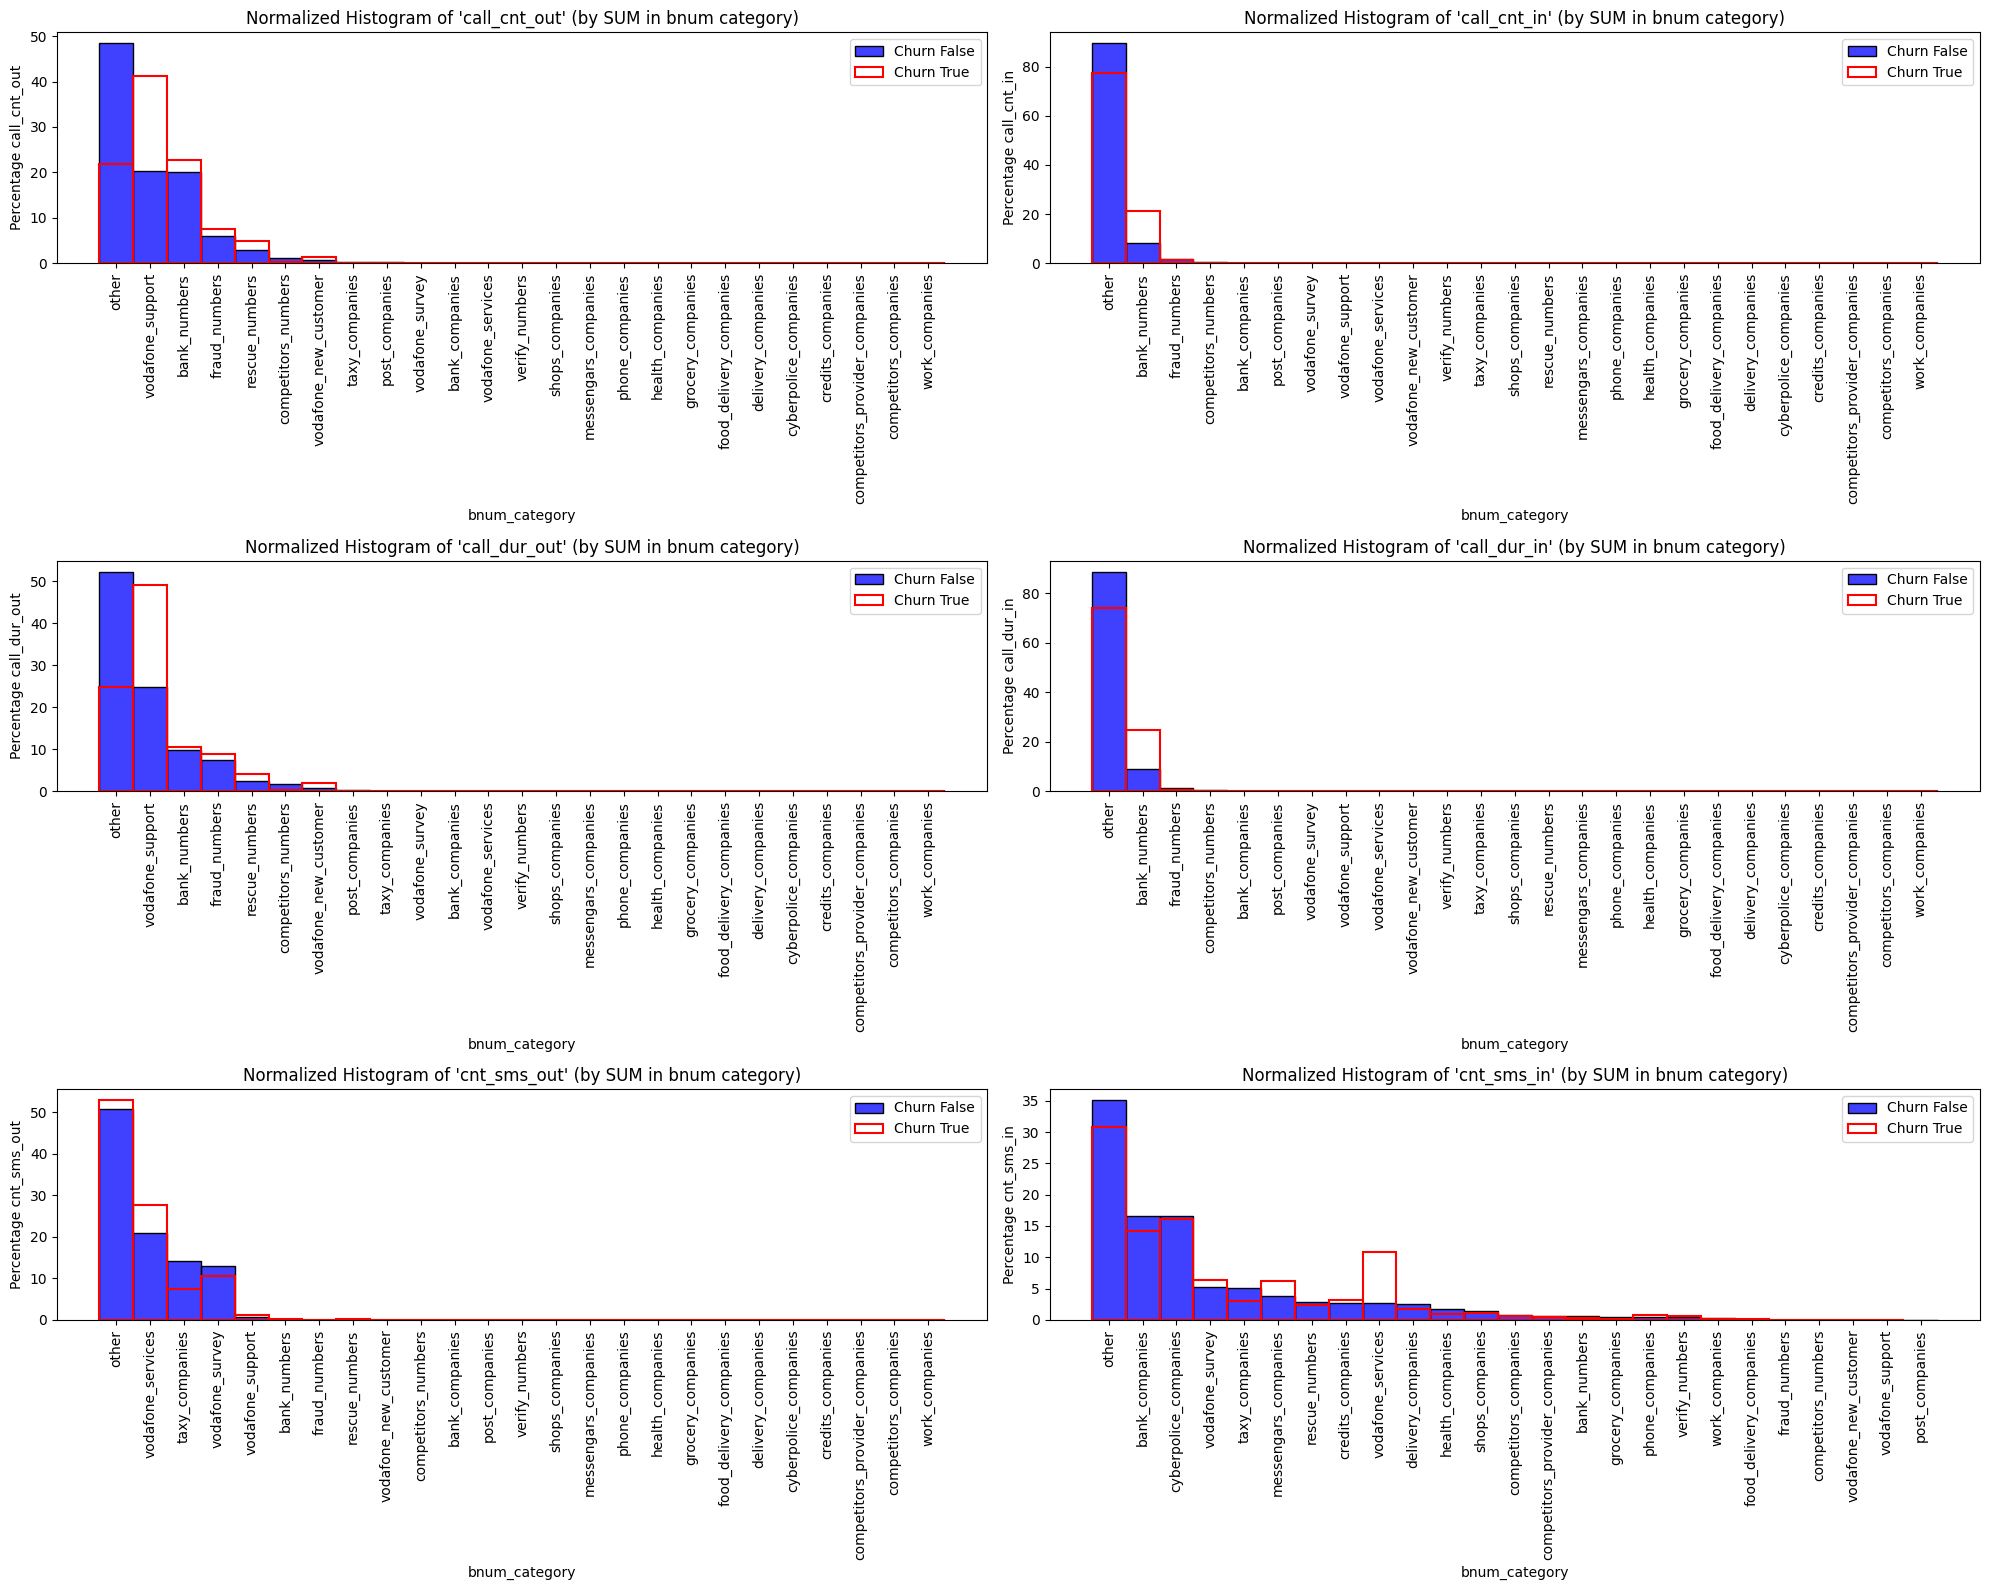

In [459]:
# Compare feature share with SUN

fig, axs = plt.subplots(3, 2, figsize=(20, 16))

for index, feature in enumerate(activity_columns):
    row = index // 2
    col = index % 2

    plt.sca(axs[row, col])
    bnum_category_grouped_feature_histplot(churn_false, feature, color="blue", label="Churn False", fill=True)
    bnum_category_grouped_feature_histplot(churn_true, feature, color="red", label="Churn True", fill=False)

    # Adding labels and title
    axs[row, col].tick_params(axis="x", rotation=90)
    axs[row, col].set_xlabel("bnum_category")
    axs[row, col].set_ylabel(f"Percentage {feature}")
    axs[row, col].set_title(f"Normalized Histogram of '{feature}' (by SUM in bnum category)")
    axs[row, col].legend()

plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()

### Vodafone Services


In [ ]:
for phone in vodafone_services:
    info = fetch_phone_information(phone)
    print(phone, info)

30094 Vodafone TV. Пакет PRO
7777 Міграція в інший тариф Vodafone
30094 Vodafone TV. Пакет PRO
5010 Гроші на замовлення
1020 Автоматичні налаштування Мобільного Інтернету 
2828 Контент-ревізор
30042 Vodafone TV. Пакет Start
vodafone u Not found


In [425]:
churn_true_vodafone_services = churn_true[churn_true.bnum_category == "vodafone_services"]

churn_true_vodafone_services_agg = churn_true_vodafone_services.groupby("bnum").sum()

churn_true_vodafone_services_agg

,call_cnt_out,call_cnt_in,call_dur_out,call_dur_in,cnt_sms_out,cnt_sms_in,abon_id,target,bnum_category,vodafone
bnum,,,,,,,,,,
1020,0.0,0.0,0.0,0.0,42.509473,6666.252844,148768522579,1404.0,vodafone_servicesvodafone_servicesvodafone_ser...,1404
2828,0.0,0.0,0.0,0.0,2.960906,48.384683,1616773416,15.0,vodafone_servicesvodafone_servicesvodafone_ser...,15
30042,0.0,0.0,0.0,0.0,5.167855,90.344040,3585904470,35.0,vodafone_servicesvodafone_servicesvodafone_ser...,35
30094,0.0,0.0,0.0,0.0,1.480453,53.033901,1316086158,12.0,vodafone_servicesvodafone_servicesvodafone_ser...,12
5010,0.0,0.0,0.0,0.0,724.652494,0.000000,37787024128,342.0,vodafone_servicesvodafone_servicesvodafone_ser...,342
7777,0.0,0.0,0.0,0.0,77.424173,244.704756,5858157509,63.0,vodafone_servicesvodafone_servicesvodafone_ser...,63
vodafone u,0.0,0.0,0.0,0.0,0.000000,99.322756,1174033644,13.0,vodafone_servicesvodafone_servicesvodafone_ser...,13


# INSIGHT: cnt_sms_in. Something wrong with 1020


In [426]:
df = churn_true_vodafone_services_agg.cnt_sms_in.reset_index()

df["share"] = df.cnt_sms_in / df.cnt_sms_in.sum()

df.sort_values("share", ascending=False)

,bnum,cnt_sms_in,share
0,1020,6666.252844,0.925606
5,7777,244.704756,0.033977
6,vodafone u,99.322756,0.013791
2,30042,90.344040,0.012544
3,30094,53.033901,0.007364
1,2828,48.384683,0.006718
4,5010,0.000000,0.000000


# INSIGHT: cnt_sms_out. Something wrong with 5010


In [427]:
df = churn_true_vodafone_services_agg.cnt_sms_out.reset_index()

df["share"] = df.cnt_sms_out / df.cnt_sms_out.sum()

df.sort_values("share", ascending=False)

,bnum,cnt_sms_out,share
4,5010,724.652494,0.848345
5,7777,77.424173,0.090640
0,1020,42.509473,0.049766
2,30042,5.167855,0.006050
1,2828,2.960906,0.003466
3,30094,1.480453,0.001733
6,vodafone u,0.000000,0.000000


### Vodafone Support


In [428]:
for phone in vodafone_support:
    info = fetch_phone_information(phone)
    print(phone, info)

111 Not found


In [429]:
churn_true_vodafone_support = churn_true[churn_true.bnum_category == "vodafone_support"]

churn_true_vodafone_support_agg = churn_true_vodafone_support.groupby("bnum").sum()

churn_true_vodafone_support_agg

,call_cnt_out,call_cnt_in,call_dur_out,call_dur_in,cnt_sms_out,cnt_sms_in,abon_id,target,bnum_category,vodafone
bnum,,,,,,,,,,
111,2471.093668,0.0,28091.101142,0.0,34.659446,0.0,92134450316,931.0,vodafone_supportvodafone_supportvodafone_suppo...,931


### Vodafone ALL


In [430]:
churn_true_vodafone = churn_true[churn_true.vodafone]

churn_true_vodafone_agg = churn_true_vodafone.groupby("bnum").sum()

churn_true_vodafone_agg

,call_cnt_out,call_cnt_in,call_dur_out,call_dur_in,cnt_sms_out,cnt_sms_in,abon_id,target,bnum_category,vodafone
bnum,,,,,,,,,,
1020,0.000000,0.0,0.000000,0.0,42.509473,6666.252844,148768522579,1404.0,vodafone_servicesvodafone_servicesvodafone_ser...,1404
111,2471.093668,0.0,28091.101142,0.0,34.659446,0.000000,92134450316,931.0,vodafone_supportvodafone_supportvodafone_suppo...,931
222,77.329690,0.0,1177.942761,0.0,0.000000,0.000000,3241099148,37.0,vodafone_new_customervodafone_new_customervoda...,37
273,0.000000,0.0,0.000000,0.0,2.206949,516.051146,5189726049,109.0,vodafone_surveyvodafone_surveyvodafone_surveyv...,109
275,1.480453,0.0,19.524976,0.0,10.308249,574.744381,3358904424,119.0,vodafone_surveyvodafone_surveyvodafone_surveyv...,119
277,0.000000,0.0,0.000000,0.0,317.438326,3152.196482,48140665029,499.0,vodafone_surveyvodafone_surveyvodafone_surveyv...,499
2828,0.000000,0.0,0.000000,0.0,2.960906,48.384683,1616773416,15.0,vodafone_servicesvodafone_servicesvodafone_ser...,15
30042,0.000000,0.0,0.000000,0.0,5.167855,90.344040,3585904470,35.0,vodafone_servicesvodafone_servicesvodafone_ser...,35
30094,0.000000,0.0,0.000000,0.0,1.480453,53.033901,1316086158,12.0,vodafone_servicesvodafone_servicesvodafone_ser...,12


# INSIGHT: cnt_sms_in. Something wrong with 1020 and 277


In [431]:
df = churn_true_vodafone_agg.cnt_sms_in.reset_index()

df["share"] = df.cnt_sms_in / df.cnt_sms_in.sum()

df.sort_values("share", ascending=False)

,bnum,cnt_sms_in,share
0,1020,6666.252844,0.582458
5,277,3152.196482,0.275420
4,275,574.744381,0.050218
3,273,516.051146,0.045090
10,7777,244.704756,0.021381
11,vodafone u,99.322756,0.008678
7,30042,90.344040,0.007894
8,30094,53.033901,0.004634
6,2828,48.384683,0.004228
1,111,0.000000,0.000000


# INSIGHT: cnt_sms_out. Something wrong with 5010 and 277


In [432]:
df = churn_true_vodafone_agg.cnt_sms_out.reset_index()

df["share"] = df.cnt_sms_out / df.cnt_sms_out.sum()

df.sort_values("share", ascending=False)

,bnum,cnt_sms_out,share
9,5010,724.652494,0.594558
5,277,317.438326,0.260450
10,7777,77.424173,0.063524
0,1020,42.509473,0.034878
1,111,34.659446,0.028437
4,275,10.308249,0.008458
7,30042,5.167855,0.004240
6,2828,2.960906,0.002429
3,273,2.206949,0.001811
8,30094,1.480453,0.001215


### Compare DIFF between churn and bnum_category


In [448]:
def build_compare_share_dataframe(bnum_df, feature_name):
    new_dataframe = pd.DataFrame({"bnum_category": bnum_df["bnum_category"].unique()})

    churn_true = bnum_df[(bnum_df["target"] == 1)]
    churn_false = bnum_df[(bnum_df["target"] == 0)]

    churn_true_with_shape = build_feature_share_df(churn_true, feature_name).drop(columns=[feature_name])
    churn_false_with_shape = build_feature_share_df(churn_false, feature_name).drop(columns=[feature_name])

    df = churn_true_with_shape.merge(churn_false_with_shape, on="bnum_category", suffixes=("_CHURN", "_NOT_CHURN"))

    df["diff"] = df[f"{feature_name}_share_CHURN"] - df[f"{feature_name}_share_NOT_CHURN"]

    return df.sort_values("diff", ascending=False)

### INSIGHT "cnt_sms_in" action

#### NOT CHURN

1. not churn abonents have bigger amount of `other`
2. not churn abonents have bigger amount of: `bank_companies, taxy_companies, health_companies, delivery_companies, rescue_numbers, shops_companies, cyberpolice_companies, grocery_companies, bank_numbers, competitors_provider_companies, competitors_companies,
work_companies, food_delivery_companies, fraud_numbers`. Більше звʼязків з телефоном (вища активність) -> менше ймовірність відтоку такого абононету

#### CHURN

1. churn clients have much bigger `vodafone_services` . Це може бути повʼязано з надмірною рекламою
2. churn clients have much bigger `messengars_companies` . Це також може бути повʼязано з надмірною рекламою, але через месенджери
3. churn clients have bigger `vodafone_survey` (також може впливати на відплив)
4. churn clients have bigger `credits_companies`
5. churn clients have bigger `phone_companies`
6. churn clients have bigger `verify_numbers`


In [476]:
build_compare_share_dataframe(df_train_bnum, "cnt_sms_in")

,bnum_category,cnt_sms_in_share_CHURN,cnt_sms_in_share_NOT_CHURN,diff
3,vodafone_services,10.826562,2.640270,8.186292
5,messengars_companies,6.188946,3.857090,2.331855
4,vodafone_survey,6.378331,5.165663,1.212668
6,credits_companies,3.192889,2.737493,0.455396
12,phone_companies,0.708706,0.469839,0.238868
14,verify_numbers,0.576358,0.433647,0.142710
21,vodafone_new_customer,0.000000,0.000000,0.000000
23,vodafone_support,0.000000,0.000000,0.000000
22,competitors_numbers,0.000000,0.000901,-0.000901
20,fraud_numbers,0.000000,0.001638,-0.001638


### INSIGHT "cnt_sms_out" action

#### NOT CHURN

1. not churn abonents have much bigger share of `taxy_companies` out sms
2. not churn abonents have bigger share of `competitors_numbers, fraud_numbers, bank_numbers` out sms
3. not churn abonents have bigger amount of `vodafone_survey`. Можливо клієнти що проходять survey більш лояльні
4. not churn abonents have bigger `vodafone_new_customer` out sms. Скоріш за все тільки прибувші клієнти

#### CHURN

1. churn clients have bigger `vodafone_services` out sms. Можливо це повʼязано з 5010 сервісом
2. churn clients have bigger `other` out sms
3. churn clinets have bigger amount of `vodafone_support` out sms. Можливо абоненти стикаються з проблемами та йдуть
4. churn clinets have bigger amount of `rescue_numbers`. Можливо щось трапляється


In [477]:
build_compare_share_dataframe(df_train_bnum, "cnt_sms_out")

,bnum_category,cnt_sms_out_share_CHURN,cnt_sms_out_share_NOT_CHURN,diff
1,vodafone_services,27.609489,20.953224,6.656265
0,other,52.978680,50.854403,2.124277
4,vodafone_support,1.120270,0.598291,0.521979
5,rescue_numbers,0.210486,0.063351,0.147134
22,competitors_companies,0.000000,0.000000,0.000000
20,competitors_provider_companies,0.000000,0.000000,0.000000
19,credits_companies,0.000000,0.000000,0.000000
18,cyberpolice_companies,0.000000,0.000000,0.000000
17,delivery_companies,0.000000,0.000000,0.000000
16,food_delivery_companies,0.000000,0.000000,0.000000


### INSIGHT "call_cnt_in" action

#### NOT CHURN

1. not churn clients have bigger amount of `competitors_numbers`. Можливо реклама від конкурентів може зменшити бажання клієнта перейти
2. not churn clients have bigger amount `fraud_numbers` of call_cnt_in. Можливо це повʼязано з тим що абонент багато де вспливає в шахрайських базах через те що номер старий, або активно його використовує
3. 

#### CHURN

1. churn clients have `much` bigger amount `bank_numbers` call cnt in. Можливо люди яких шукає банк більш схильні змінювати номера телефонів


In [464]:
build_compare_share_dataframe(df_train_bnum, "call_cnt_in")

,bnum_category,call_cnt_in_share_CHURN,call_cnt_in_share_NOT_CHURN,diff
1,bank_numbers,21.277576,8.193428,13.084149
12,phone_companies,0.000000,0.000000,0.000000
22,competitors_companies,0.000000,0.000000,0.000000
20,competitors_provider_companies,0.000000,0.000000,0.000000
19,credits_companies,0.000000,0.000000,0.000000
18,cyberpolice_companies,0.000000,0.000000,0.000000
17,delivery_companies,0.000000,0.000000,0.000000
16,food_delivery_companies,0.000000,0.000000,0.000000
15,grocery_companies,0.000000,0.000000,0.000000
14,health_companies,0.000000,0.000000,0.000000


### INSIGHT "call_cnt_out" action

#### NOT CHURN

1. not churn clients have `much` bigger share of `other` category. Maybe they use it actively
2. not churn clinets have bigger `competitors_numbers`. Можливо в цих юзерів вже є номери конкурентів
3. not churn clinets have bigger `taxy_companies` . Активно використовують ці номера

#### CHURN

1. churn abonents have bigger `vodafone_new_customer` share. Можливо коли нові клієнти часто отримають негативний досвід на початку, вони потім йдуть
2. churn abonents have bigger `fraud_numbers` share. Не знаю як пояснити
3. churn abonents have bigger `rescue_numbers` share. Можливо з клієнтами щось трапляється і вони перестають користуватись послугами
4. churn abonents have `much` bigger share of `vodafone_support` . Скоріш за все клієнти незадоволені сервісом, і саппорт не може їм з цим допомогти


In [479]:
build_compare_share_dataframe(df_train_bnum, "call_cnt_out")

,bnum_category,call_cnt_out_share_CHURN,call_cnt_out_share_NOT_CHURN,diff
0,vodafone_support,41.280562,20.383524,20.897038
1,bank_numbers,22.774630,20.142773,2.631857
4,rescue_numbers,4.962608,2.905254,2.057354
3,fraud_numbers,7.521612,5.997702,1.523910
5,vodafone_new_customer,1.291822,0.653368,0.638454
8,vodafone_survey,0.024732,0.021422,0.003310
15,health_companies,0.000000,0.000000,0.000000
22,competitors_companies,0.000000,0.000000,0.000000
21,competitors_provider_companies,0.000000,0.000000,0.000000
20,credits_companies,0.000000,0.000000,0.000000


### INSIGHT "call_dur_out" action

#### NOT CHURN

1. not churn clints have `much` higher amount of `other`. Клієнти активно користуються номером телефона
2. not churn clients have bigger amount of `competitors_numbers`. Можливо в них вже є інші номери

#### CHURN

1. churn clients have `much` bigger `vodafone_support`. Клієнти чимось незадоволені, довго не можуть вирішити свою проблему. Може час очікування
2. churn clients have `much` bigger `rescue_numbers`
3. churn clients have bigger amount of `fraud_numbers` Можливо клієнти що схильні до відтоку довше говорять з шахраями
4. churn clients have bigger amount of `vodafone_new_customer` . Нові клієнти стикаються з якимось труднощами
5. churn clients have bigger share of `vodafone_survey`. Можливо варто змінити кількість та тривалість survey дзвінків


In [480]:
build_compare_share_dataframe(df_train_bnum, "call_dur_out")

,bnum_category,call_dur_out_share_CHURN,call_dur_out_share_NOT_CHURN,diff
0,vodafone_support,49.105751,24.824498,24.281253
4,rescue_numbers,4.092437,2.518048,1.574389
3,fraud_numbers,8.842039,7.485234,1.356805
5,vodafone_new_customer,2.059149,0.921100,1.138049
2,bank_numbers,10.677090,9.831013,0.846077
7,vodafone_survey,0.034131,0.016226,0.017905
15,health_companies,0.000000,0.000000,0.000000
22,competitors_companies,0.000000,0.000000,0.000000
21,competitors_provider_companies,0.000000,0.000000,0.000000
20,credits_companies,0.000000,0.000000,0.000000


### INSIGHT "call_dur_in" action

#### NOT CHURN

1. Not churn clinets have bigger amount of `other`
2. Not churn clients have bigger amount of `competitors_numbers` Можливо вже є номери конкурентів
1. Not churn clinets have bigger amount of `fraud_numbers` . Поки не можу сказати чому

#### CHURN

1. churn clients have `much` bigger amount of `bank_numbers` call dur in. Можливо клієнти від яких щось хоче банк, частіше змінюються телефон


In [482]:
build_compare_share_dataframe(df_train_bnum, "call_dur_in")

,bnum_category,call_dur_in_share_CHURN,call_dur_in_share_NOT_CHURN,diff
1,bank_numbers,24.968526,9.141116,15.827410
12,phone_companies,0.000000,0.000000,0.000000
22,competitors_companies,0.000000,0.000000,0.000000
20,competitors_provider_companies,0.000000,0.000000,0.000000
19,credits_companies,0.000000,0.000000,0.000000
18,cyberpolice_companies,0.000000,0.000000,0.000000
17,delivery_companies,0.000000,0.000000,0.000000
16,food_delivery_companies,0.000000,0.000000,0.000000
15,grocery_companies,0.000000,0.000000,0.000000
14,health_companies,0.000000,0.000000,0.000000
